In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from datetime import timedelta 

In [2]:
# Convert muneric profit/Loss to Movement
def move(x):
    if x >= 0:
        x = 1
    else:
        x = 0
    return x 

In [3]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [4]:
def data_cleaning(text):
    token = word_tokenize(text) # tokenize the text into token (1gram- word)
    token = [w.lower() for w in token] # lower the words into lower case
    table = str.maketrans('', '', string.punctuation) # remove punctuation
    stripped = [w.translate(table) for w in token] 
    word = [word for word in token if word.isalpha()] # remove non- alphabetic symbol
    word = [w for w in word if not w in stopword] # remove stop word
    text = "".join([" "+ i for i in word]).strip()
    return text 

In [5]:
lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [6]:
def performance(actual, predicted, predicted_proba):
    CFmat = confusion_matrix(actual, predicted)
    fig, ax = plt.subplots(figsize = (2.5,2.5))
    ax.matshow(CFmat, cmap = plt.cm.Blues, alpha = 0.5)
    for i in range(CFmat.shape[0]):
        for j in range(CFmat.shape[1]):
            ax.text(x = j, y = i, s = CFmat[i,j], va = "center", ha = "center")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual (True) Class")
    plt.show()
    print(classification_report(actual,predicted))
    fpr, tpr, thresholds = roc_curve(actual, predicted_proba[:,1])
    roc_auc = auc(fpr, tpr)
    plt.title("Receiver Operating Characteristic Curve")
    plt.plot(fpr, tpr, "b", marker = "o", label = "AUC = %0.3f" % roc_auc)
    plt.legend(loc = "lower right")
    plt.plot([0,1],[0,1], "r--")
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel("True Positive rate (Recall)")
    plt.xlabel("False Positive rate")
    plt.show()
    return roc_auc

In [7]:
def score(actual, predicted_proba):
    fpr, tpr, thresholds = roc_curve(actual, predicted_proba[:,1])
    roc_auc = auc(fpr, tpr)
    return (roc_auc)

# Read data and preprocessing

In [8]:
df= pd.read_csv("/Users/andrewyu/MFIT 5003 /Project/raw_news.csv")
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,2,Agilent Technologies Announces Pricing of $5……...,http://www.gurufocus.com/news/1153187/agilent-...,GuruFocus,2020-06-01 00:00:00,A
1,3,Agilent (A) Gears Up for Q2 Earnings: What's i...,http://www.zacks.com/stock/news/931205/agilent...,Zacks,2020-05-18 00:00:00,A
2,4,J.P. Morgan Asset Management Announces Liquida...,http://www.gurufocus.com/news/1138923/jp-morga...,GuruFocus,2020-05-15 00:00:00,A
3,5,"Pershing Square Capital Management, L.P. Buys ...",http://www.gurufocus.com/news/1138704/pershing...,GuruFocus,2020-05-15 00:00:00,A
4,6,Agilent Awards Trilogy Sciences with a Golden ...,http://www.gurufocus.com/news/1134012/agilent-...,GuruFocus,2020-05-12 00:00:00,A


In [9]:
df.date = pd.to_datetime(df.date)

In [10]:
df = df[df.date >= "2012-01-01"]

In [11]:
df.groupby("date").agg(numer_of_nuews = pd.NamedAgg(column = "headline", aggfunc = len))

,numer_of_nuews
date,
2012-01-01,89
2012-01-02,71
2012-01-03,269
2012-01-04,312
2012-01-05,120
...,...
2020-05-31,109
2020-06-01,372
2020-06-02,338


In [12]:
df.tail()

,Unnamed: 0,headline,url,publisher,date,stock
1845554,1849874,Consumer Cyclical Sector Wrap,https://www.benzinga.com/content/12/08/2846030...,webmaster,2012-08-20,ZX
1845555,1849875,Consumer Cyclical Sector Wrap,https://www.benzinga.com/content/12/07/2767124...,webmaster,2012-07-23,ZX
1845556,1849876,Zacks #5 Rank Additions for Monday - Tale of t...,http://www.zacks.com/stock/news/73497/here-are...,Zacks,2012-04-23,ZX
1845557,1849877,4 Stock Strategies From Wall Street: Feb. 9 (U...,http://www.thestreet.com/story/11409053/1/4-st...,TheStreet.Com,2012-02-09,ZX
1845558,1849878,4 Stock Strategies From Wall Street: Feb. 9,https://www.benzinga.com/content/thestreet-com...,webmaster,2012-02-09,ZX


In [13]:
price = pd.read_csv("/Users/andrewyu/MFIT 5003 /Project/sp500.csv")
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,1258.859985,1284.619995,1258.859985,1277.060059,1277.060059,3943710000
1,2012-01-04,1277.030029,1278.729980,1268.099976,1277.300049,1277.300049,3592580000
2,2012-01-05,1277.300049,1283.050049,1265.260010,1281.060059,1281.060059,4315950000
3,2012-01-06,1280.930054,1281.839966,1273.339966,1277.810059,1277.810059,3656830000
4,2012-01-09,1277.829956,1281.989990,1274.550049,1280.699951,1280.699951,3371600000


In [14]:
profit = np.diff(price["Adj Close"])
row1 = price.iloc[0,5] - price.iloc[0,1] 
Movement = np.append(row1, profit)

In [15]:
price = pd.DataFrame({"date": price.Date, "Movement": Movement})

In [16]:
price.Movement = price.Movement.apply(move)

In [17]:
price

,date,Movement
0,2012-01-03,1
1,2012-01-04,1
2,2012-01-05,1
3,2012-01-06,0
4,2012-01-09,1
...,...,...
2115,2020-06-01,1
2116,2020-06-02,1
2117,2020-06-03,1
2118,2020-06-04,0


In [18]:
price.date = pd.to_datetime(price.date)

In [19]:
df = pd.merge(df, price, on= "date", how = "left")

In [20]:
df['Movement'].isnull().sum()

131683

In [21]:
# add 1 day if the release day is a holiday
count = 9999
while count !=0 :
    df.loc[df.Movement.isnull(), "date"] = df.loc[df.Movement.isnull(), "date"] + pd.Timedelta(days=1) 
    df = df.drop(columns = "Movement")
    df = pd.merge(df, price, on= "date", how = "left")
    count = df['Movement'].isnull().sum()
    print(count)

54113
6309
13
0


In [22]:
df.head()

,Unnamed: 0,headline,url,publisher,date,stock,Movement
0,2,Agilent Technologies Announces Pricing of $5……...,http://www.gurufocus.com/news/1153187/agilent-...,GuruFocus,2020-06-01,A,1
1,3,Agilent (A) Gears Up for Q2 Earnings: What's i...,http://www.zacks.com/stock/news/931205/agilent...,Zacks,2020-05-18,A,1
2,4,J.P. Morgan Asset Management Announces Liquida...,http://www.gurufocus.com/news/1138923/jp-morga...,GuruFocus,2020-05-15,A,1
3,5,"Pershing Square Capital Management, L.P. Buys ...",http://www.gurufocus.com/news/1138704/pershing...,GuruFocus,2020-05-15,A,1
4,6,Agilent Awards Trilogy Sciences with a Golden ...,http://www.gurufocus.com/news/1134012/agilent-...,GuruFocus,2020-05-12,A,0


In [23]:
df = df.drop(["Unnamed: 0", "url", "stock", "publisher"], axis = 1)

In [24]:
df.head()

,headline,date,Movement
0,Agilent Technologies Announces Pricing of $5……...,2020-06-01,1
1,Agilent (A) Gears Up for Q2 Earnings: What's i...,2020-05-18,1
2,J.P. Morgan Asset Management Announces Liquida...,2020-05-15,1
3,"Pershing Square Capital Management, L.P. Buys ...",2020-05-15,1
4,Agilent Awards Trilogy Sciences with a Golden ...,2020-05-12,0


In [25]:
df["headline"] = df[['date','Movement','headline']].groupby(['date'])['headline'].transform(lambda x: ' '.join(x))


In [26]:
df = df[['date','Movement','headline']].drop_duplicates()

In [27]:
df.shape

(2112, 3)

In [28]:
stopword = stopwords.words('english')
df.headline = df.headline.apply(data_cleaning)
df.headline = df.headline.apply(lemmatize_sentence)

In [29]:
# split the data into train set and test set by dat (60-20-20)
len(df)*0.2

422.40000000000003

In [30]:
(df.date >= "2018-10-01").sum()

422

In [31]:
(df.date >= "2017-02-01").sum()

841

In [32]:
test = df[df.date >= "2018-10-01"]
validation = df[(df.date >= "2017-02-01") & (df.date < "2018-10-01")]
train = df[df.date < "2017-02-01"]

In [33]:
len(train)

1271

In [34]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
validation = validation.reset_index(drop=True)

In [35]:
train.head()

,date,Movement,headline
0,2016-12-20,1,agilent acquire belgian molecular diagnostics ...
1,2016-12-09,1,cancer immunotherapy market takeaway expect al...
2,2016-12-06,1,agilent technology raise dividend small indust...
3,2016-11-30,0,growth stock land value stock goldcorp outshin...
4,2016-11-17,1,agilent technology declare dividend share adva...


# Exploratory Data analysis

AxesSubplot(0.125,0.125;0.775x0.755)


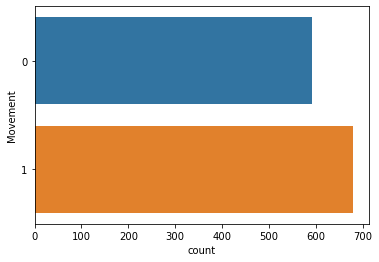

In [36]:
print(sns.countplot(y="Movement", data=train))

In [37]:
UP = train[train.Movement == 1] 
DOWN = train[train.Movement == 0]

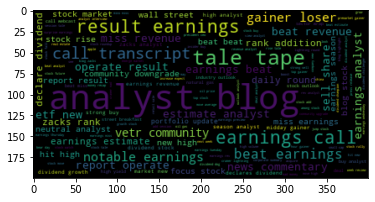

In [38]:
wordcloud = WordCloud(max_words=200).generate(" ".join(UP.headline))
plt.imshow(wordcloud,interpolation = 'bilinear')

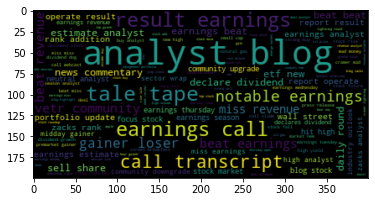

In [39]:
wordcloud = WordCloud(max_words=200).generate(" ".join(DOWN.headline))
plt.imshow(wordcloud,interpolation = 'bilinear')

In [40]:
text = " ".join(UP.headline)
most_occur = Counter(text.split()).most_common(20)

In [41]:
pd.DataFrame(most_occur, columns = ["word", "frequency"])

,word,frequency
0,analyst,84487
1,blog,80696
2,stock,61591
3,earnings,50530
4,beat,22089
5,dividend,21749
6,result,20968
7,high,19596
8,buy,18537
9,tale,16606


In [42]:
text = " ".join(DOWN.headline)
most_occur = Counter(text.split()).most_common(20)
pd.DataFrame(most_occur, columns = ["word", "frequency"])

,word,frequency
0,analyst,70855
1,blog,67298
2,stock,55864
3,earnings,47597
4,result,21012
5,dividend,20271
6,beat,19394
7,buy,17335
8,market,15308
9,high,15115


# Features Enginnering - bag of word

In [78]:
# initail approach - bag of words counting Vectorizer
basicvectorizer = CountVectorizer(ngram_range=(1,1))
basictrain = basicvectorizer.fit_transform(train.headline)
print(basictrain.shape)

(1271, 46216)


In [79]:
basictest = basicvectorizer.transform(test.headline)
basicvalidation = basicvectorizer.transform(validation.headline)

# Initial Model - XGBoost for all features

In [80]:
mod1 = XGBClassifier(n_jobs = -1, random_state=42, seed=2, n_estimators = 100, max_depth = 6, learning_rate = 0.1,
                    subsample = 0.75, colsample_bytree = 0.75, reg_alpha = 0, reg_lambda = 1)


In [81]:
fit1 = mod1.fit(basictrain, train.Movement)

pred1_train = fit1.predict(basictrain)
pred1_proba_train = fit1.predict_proba(basictrain)

pred1 = fit1.predict(basicvalidation)
pred1_proba = fit1.predict_proba(basicvalidation)

pred1_test = fit1.predict(basictest)
pred1_proba_test = fit1.predict_proba(basictest)

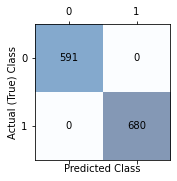

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       680

    accuracy                           1.00      1271
   macro avg       1.00      1.00      1.00      1271
weighted avg       1.00      1.00      1.00      1271



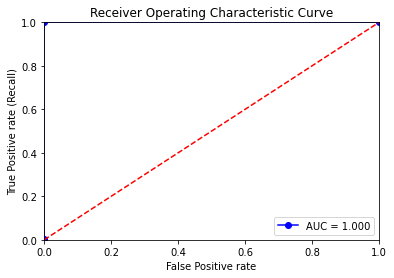

1.0

In [82]:
performance(train.Movement, pred1_train, pred1_proba_train)

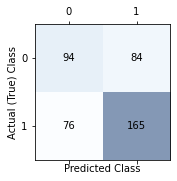

              precision    recall  f1-score   support

           0       0.55      0.53      0.54       178
           1       0.66      0.68      0.67       241

    accuracy                           0.62       419
   macro avg       0.61      0.61      0.61       419
weighted avg       0.62      0.62      0.62       419



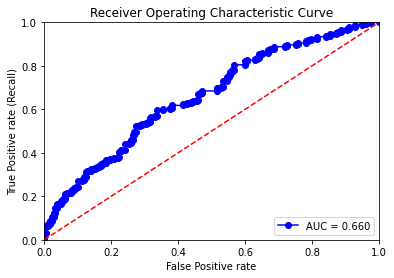

0.6602755373210872

In [83]:
performance(validation.Movement, pred1, pred1_proba)

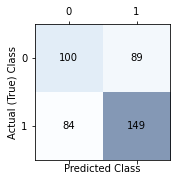

              precision    recall  f1-score   support

           0       0.54      0.53      0.54       189
           1       0.63      0.64      0.63       233

    accuracy                           0.59       422
   macro avg       0.58      0.58      0.58       422
weighted avg       0.59      0.59      0.59       422



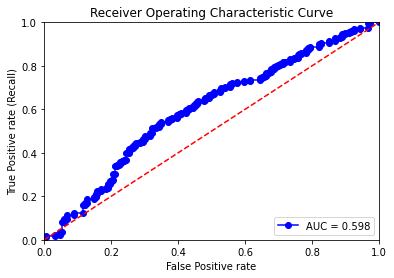

0.5984285941367486

In [85]:
performance(test.Movement, pred1_test, pred1_proba_test)

In [42]:
sum(np.array(fit1.feature_importances_) == 0 )

44952

In [43]:
max(np.array(fit1.feature_importances_))

0.00505468

# Back to Features Enginnering
### Noted that, validation set performance is used to select the best model

In [60]:
# Impute Td-idf instead, we also limit the max appearance and min aappearance of a word to be used in the model. By doing so, many useless features will be eliminated. 
# A gird search is performed to find the best min_df and max_df assuming no change on other hyperparameter of XGBoost yet.

min_df = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15]
max_df = [0.9, 0.92, 0.94, 0.96, 0.98, 1]

auc_score = np.zeros((len(min_df), len(max_df)))

for i in range(len(min_df)):
    for j in range(len(max_df)):
        if max_df[j] == 1:
            basicvectorizer = TfidfVectorizer(ngram_range=(1,1), min_df = min_df[i])
        else:
            basicvectorizer = TfidfVectorizer(ngram_range=(1,1), min_df = min_df[i], max_df = max_df[j])
        basictrain = basicvectorizer.fit_transform(train.headline)
        basictest = basicvectorizer.transform(test.headline)
        basicvalidation = basicvectorizer.transform(validation.headline)
        
        fit2 = mod1.fit(basictrain, train.Movement)
        pred2 = fit2.predict(basicvalidation)
        pred2_proba = fit2.predict_proba(basicvalidation)
        auc_score[i,j] = score(validation.Movement, pred2_proba)
        print("Finished the model with min_df =", min_df[i], "and max_df = ", max_df[j])

Finished the model with min_df = 0 and max_df =  0.9
Finished the model with min_df = 0 and max_df =  0.92
Finished the model with min_df = 0 and max_df =  0.94
Finished the model with min_df = 0 and max_df =  0.96
Finished the model with min_df = 0 and max_df =  0.98
Finished the model with min_df = 0 and max_df =  1
Finished the model with min_df = 0.025 and max_df =  0.9
Finished the model with min_df = 0.025 and max_df =  0.92
Finished the model with min_df = 0.025 and max_df =  0.94
Finished the model with min_df = 0.025 and max_df =  0.96
Finished the model with min_df = 0.025 and max_df =  0.98
Finished the model with min_df = 0.025 and max_df =  1
Finished the model with min_df = 0.05 and max_df =  0.9
Finished the model with min_df = 0.05 and max_df =  0.92
Finished the model with min_df = 0.05 and max_df =  0.94
Finished the model with min_df = 0.05 and max_df =  0.96
Finished the model with min_df = 0.05 and max_df =  0.98
Finished the model with min_df = 0.05 and max_df =  

In [61]:
auc_score.max(axis = 1)

array([0.64042613, 0.63581053, 0.65891184, 0.6544361 , 0.66019395,
       0.65721013, 0.63734906])

In [62]:
auc_score.max(axis = 0)

array([0.59737051, 0.62096135, 0.64755933, 0.66019395, 0.65891184,
       0.65721013])

In [63]:
auc_score[4, 3]

0.6601939484358245

Therefore, we set min_df as 0.1 and max_df as 0.96

In [86]:
basicvectorizer = TfidfVectorizer(ngram_range=(1,1), min_df = 0.1, max_df = 0.96)
basictrain = basicvectorizer.fit_transform(train.headline)
print(basictrain.shape)

(1271, 2113)


In [87]:
basictest = basicvectorizer.transform(test.headline)
basicvalidation = basicvectorizer.transform(validation.headline)

In [88]:
fit2 = mod1.fit(basictrain, train.Movement)

pred2_train = fit2.predict(basictrain)
pred2_proba_train = fit2.predict_proba(basictrain)

pred2 = fit2.predict(basicvalidation)
pred2_proba = fit2.predict_proba(basicvalidation)

pred2_test = fit2.predict(basictest)
pred2_proba_test = fit2.predict_proba(basictest)

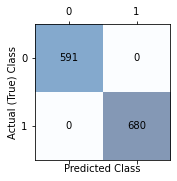

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       680

    accuracy                           1.00      1271
   macro avg       1.00      1.00      1.00      1271
weighted avg       1.00      1.00      1.00      1271



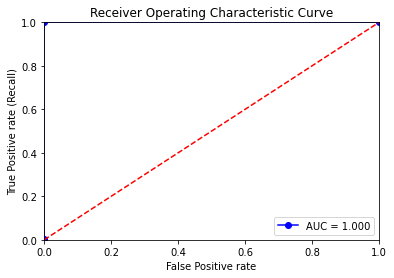

1.0

In [89]:
performance(train.Movement, pred2_train, pred2_proba_train)

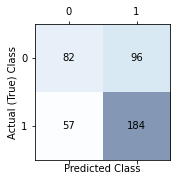

              precision    recall  f1-score   support

           0       0.59      0.46      0.52       178
           1       0.66      0.76      0.71       241

    accuracy                           0.63       419
   macro avg       0.62      0.61      0.61       419
weighted avg       0.63      0.63      0.63       419



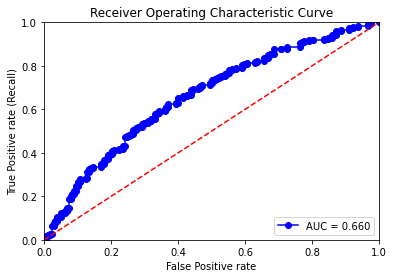

0.6601939484358245

In [90]:
performance(validation.Movement, pred2, pred2_proba)

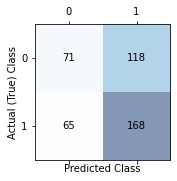

              precision    recall  f1-score   support

           0       0.52      0.38      0.44       189
           1       0.59      0.72      0.65       233

    accuracy                           0.57       422
   macro avg       0.55      0.55      0.54       422
weighted avg       0.56      0.57      0.55       422



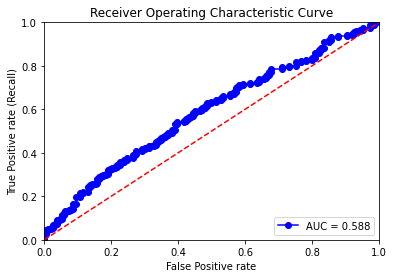

0.5878011672003088

In [91]:
performance(test.Movement, pred2_test, pred2_proba_test)

# Hyperparameter turning
As the data is NOT i.i.d, a CV approach is NOT appropecate and thus, the validation set AUC is the only way to perform model selection.

Indeed, one should consider the pervious min_df and max_df as hyperparameter as well. However, due to the computational limitation, we do it seperately.

Here, we set learning_rate as 0.1 and control n_estimators, the number of weak learner. 
max_depth is to control the complexity of each weak learner.
subsample ratio and colsample_bytree is to control the randomness of each step. 
Finally, reg_alpha and reg_lambda is the parameters to add L1 and L2 penalty.

In [92]:
n_estimators = [10, 30, 50, 100, 150]
max_depth = [1, 2, 4, 6]
learning_rate = 0.1
subsample = [0.25, 0.5, 0.75, 1]
colsample_bytree = [0.25, 0.5, 0.75, 1]
reg_alpha = [0, 1, 2]
reg_lambda = [0, 1, 2]

auc_score = np.zeros((len(n_estimators), len(max_depth), len(subsample), 
               len(colsample_bytree), len(reg_alpha), len(reg_lambda)))

In [93]:
for i in range(len(n_estimators)):
    for j in range(len(max_depth)):
        for k in range(len(subsample)):
            for l in range(len(colsample_bytree)):
                for m in range(len(reg_alpha)):
                    for n in range(len(reg_lambda)):
                        mod = XGBClassifier(learning_rate = learning_rate, 
                                            n_estimators = n_estimators[i], 
                                            max_depth = max_depth[j], 
                                            subsample = subsample[k],
                                            colsample_bytree = colsample_bytree[l],
                                            reg_alpha = reg_alpha[m],
                                            reg_lambda = reg_lambda[n], 
                                            random_state = 42, seed = 2, n_jobs = -1)
                        fit = mod.fit(basictrain, train.Movement)
                        pred = fit.predict(basicvalidation)
                        pred_proba = fit.predict_proba(basicvalidation)
                        auc_score[i,j,k,l,m,n] = score(validation.Movement, pred_proba)
    print("Finished the all models with n_estimators =", n_estimators[i])


Finished the all models with n_estimators = 10
Finished the all models with n_estimators = 30
Finished the all models with n_estimators = 50
Finished the all models with n_estimators = 100
Finished the all models with n_estimators = 150


In [96]:
auc_score.max(axis = 5).max(axis = 4).max(axis = 3).max(axis = 2).max(axis = 1)

array([0.66392373, 0.68208308, 0.6804513 , 0.68035806, 0.68313208])

In general, we expect to see a convex curve and thus, the second, n_estimators = 30 is chosen


In [103]:
auc_score[1, :, :, :, :, :].max(axis = 4).max(axis = 3).max(axis = 2).max(axis = 1)

array([0.67013614, 0.674472  , 0.66788661, 0.68208308])

In [104]:
auc_score[1, :, :, :, :, :].max(axis = 4).max(axis = 3).max(axis = 2).max(axis = 0)

array([0.68208308, 0.67013614, 0.66711735, 0.674472  ])

In [105]:
auc_score[1, :, :, :, :, :].max(axis = 4).max(axis = 3).max(axis = 1).max(axis = 0)

array([0.67013614, 0.68208308, 0.66242016, 0.66711735])

In [106]:
auc_score[1, :, :, :, :, :].max(axis = 4).max(axis = 2).max(axis = 1).max(axis = 0)

array([0.674472  , 0.68208308, 0.67013614])

In [107]:
auc_score[1, :, :, :, :, :].max(axis = 3).max(axis = 2).max(axis = 1).max(axis = 0)

array([0.66690755, 0.674472  , 0.68208308])

We choose hyperparameter:

n_estimators = 30

max_depth = 6

subsample = 0.25

colsample_bytree = 0.5

reg_alpha = 1

reg_lambda = 2

As our finalised initial model

# Finallised initial model

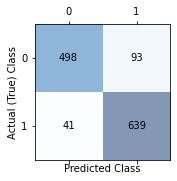

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       591
           1       0.87      0.94      0.91       680

    accuracy                           0.89      1271
   macro avg       0.90      0.89      0.89      1271
weighted avg       0.90      0.89      0.89      1271



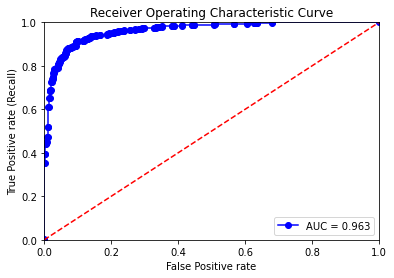

0.9632004578481138

In [92]:
basicvectorizer = TfidfVectorizer(ngram_range=(1,1), min_df = 0.1, max_df = 0.96)
basictrain = basicvectorizer.fit_transform(train.headline)
basictest = basicvectorizer.transform(test.headline)
basicvalidation = basicvectorizer.transform(validation.headline)

mod1 = XGBClassifier(n_estimators = 30, 
                     learning_rate =0.1, 
                     max_depth=6,
                     subsample = 0.25,
                     colsample_bytree = 0.5,
                     reg_alpha = 1,
                     reg_lambda = 2,
                     random_state=42, seed=2, n_jobs = -1)

fit1 = mod1.fit(basictrain, train.Movement)

pred1_train = fit1.predict(basictrain)
pred1_proba_train = fit1.predict_proba(basictrain)

pred1 = fit1.predict(basicvalidation)
pred1_proba = fit1.predict_proba(basicvalidation)

pred1_test = fit1.predict(basictest)
pred1_proba_test = fit1.predict_proba(basictest)

performance(train.Movement, pred1_train, pred1_proba_train)

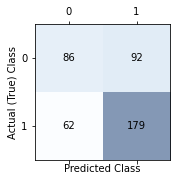

              precision    recall  f1-score   support

           0       0.58      0.48      0.53       178
           1       0.66      0.74      0.70       241

    accuracy                           0.63       419
   macro avg       0.62      0.61      0.61       419
weighted avg       0.63      0.63      0.63       419



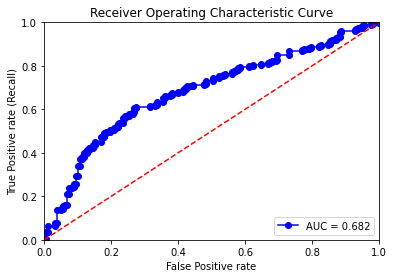

0.6820830807963075

In [93]:
performance(validation.Movement, pred1, pred1_proba)

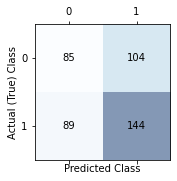

              precision    recall  f1-score   support

           0       0.49      0.45      0.47       189
           1       0.58      0.62      0.60       233

    accuracy                           0.54       422
   macro avg       0.53      0.53      0.53       422
weighted avg       0.54      0.54      0.54       422



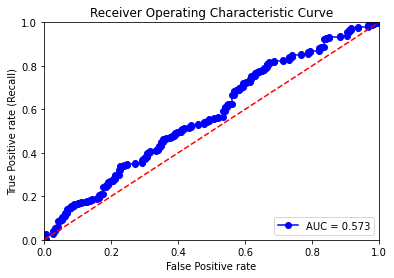

0.573108976542453

In [94]:
performance(test.Movement, pred1_test, pred1_proba_test)

In [110]:
mod1words = basicvectorizer.get_feature_names()
fi = fit1.feature_importances_
fidf = pd.DataFrame({'Words' : mod1words, 
                        'Feature Importance' : fi})

fidf = fidf.sort_values(['Feature Importance', 'Words'], ascending=[0, 1])
fidf.head(20)

,Words,Feature Importance
1468,pull,0.006272
1104,low,0.006120
1910,tom,0.005918
170,beat,0.005839
1881,tesla,0.005832
1125,manage,0.005654
1484,quiet,0.005589
1908,today,0.005522
2082,woe,0.005454
1044,launch,0.005381


# 2-grams models for feature selection

In [111]:
# Impute Td-idf instead, we also limit the max appearance and min aappearance of a word to be used in the model. By doing so, many useless features will be eliminated. 
# A gird search is performed to find the best min_df and max_df assuming no change on other hyperparameter of XGBoost yet.
# inheritect the model from our initial model

mod2 = XGBClassifier(n_estimators = 30, 
                     learning_rate =0.1, 
                     max_depth=6,
                     subsample = 0.25,
                     colsample_bytree = 0.5,
                     reg_alpha = 1,
                     reg_lambda = 2,
                     random_state=42, seed=2, n_jobs = -1)

min_df = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
max_df = [0.75,0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1]

auc_score = np.zeros((len(min_df), len(max_df)))

for i in range(len(min_df)):
    for j in range(len(max_df)):
        if max_df[j] == 1:
            basicvectorizer = TfidfVectorizer(ngram_range=(2,2), min_df = min_df[i])
        else:
            basicvectorizer = TfidfVectorizer(ngram_range=(2,2), min_df = min_df[i], max_df = max_df[j])
        basictrain = basicvectorizer.fit_transform(train.headline)
        basictest = basicvectorizer.transform(test.headline)
        basicvalidation = basicvectorizer.transform(validation.headline)
        
        fit2 = mod2.fit(basictrain, train.Movement)
        pred2 = fit2.predict(basicvalidation)
        pred2_proba = fit2.predict_proba(basicvalidation)
        auc_score[i,j] = score(validation.Movement, pred2_proba)
        print("Finished the model with min_df =", min_df[i], "and max_df = ", max_df[j])

Finished the model with min_df = 0 and max_df =  0.75
Finished the model with min_df = 0 and max_df =  0.775
Finished the model with min_df = 0 and max_df =  0.8
Finished the model with min_df = 0 and max_df =  0.825
Finished the model with min_df = 0 and max_df =  0.85
Finished the model with min_df = 0 and max_df =  0.875
Finished the model with min_df = 0 and max_df =  0.9
Finished the model with min_df = 0 and max_df =  0.925
Finished the model with min_df = 0 and max_df =  0.95
Finished the model with min_df = 0 and max_df =  0.975
Finished the model with min_df = 0 and max_df =  1
Finished the model with min_df = 0.005 and max_df =  0.75
Finished the model with min_df = 0.005 and max_df =  0.775
Finished the model with min_df = 0.005 and max_df =  0.8
Finished the model with min_df = 0.005 and max_df =  0.825
Finished the model with min_df = 0.005 and max_df =  0.85
Finished the model with min_df = 0.005 and max_df =  0.875
Finished the model with min_df = 0.005 and max_df =  0.9

In [114]:
auc_score.max(axis = 0)

array([0.61375822, 0.63145135, 0.63145135, 0.63145135, 0.63145135,
       0.63145135, 0.63145135, 0.63145135, 0.63145135, 0.63145135,
       0.63145135])

In [115]:
auc_score.max(axis = 1)

array([0.61737144, 0.63145135, 0.61375822, 0.56370926, 0.60995851,
       0.5830808 , 0.57704322, 0.60079724, 0.60670661])

In [95]:
basicvectorizer = TfidfVectorizer(ngram_range=(2,2), min_df = 0.005, max_df = 0.975)
basictrain = basicvectorizer.fit_transform(train.headline)
basictest = basicvectorizer.transform(test.headline)
basicvalidation = basicvectorizer.transform(validation.headline)

# Hyperparameter Truning

In [118]:
n_estimators = [10, 30, 50, 100, 150]
max_depth = [1, 2, 4, 6]
learning_rate = 0.1
subsample = [0.25, 0.5, 0.75, 1]
colsample_bytree = [0.25, 0.5, 0.75, 1]
reg_alpha = [0, 1, 2]
reg_lambda = [0, 1, 2]

auc_score = np.zeros((len(n_estimators), len(max_depth), len(subsample), 
               len(colsample_bytree), len(reg_alpha), len(reg_lambda)))

In [119]:
for i in range(len(n_estimators)):
    for j in range(len(max_depth)):
        for k in range(len(subsample)):
            for l in range(len(colsample_bytree)):
                for m in range(len(reg_alpha)):
                    for n in range(len(reg_lambda)):
                        mod = XGBClassifier(learning_rate = learning_rate, 
                                            n_estimators = n_estimators[i], 
                                            max_depth = max_depth[j], 
                                            subsample = subsample[k],
                                            colsample_bytree = colsample_bytree[l],
                                            reg_alpha = reg_alpha[m],
                                            reg_lambda = reg_lambda[n], 
                                            random_state = 42, seed = 2, n_jobs = -1)
                        fit = mod.fit(basictrain, train.Movement)
                        pred = fit.predict(basicvalidation)
                        pred_proba = fit.predict_proba(basicvalidation)
                        auc_score[i,j,k,l,m,n] = score(validation.Movement, pred_proba)
    print("Finished the all models with n_estimators =", n_estimators[i])



Finished the all models with n_estimators = 10
Finished the all models with n_estimators = 30
Finished the all models with n_estimators = 50
Finished the all models with n_estimators = 100
Finished the all models with n_estimators = 150


In [123]:
auc_score.max(axis = 5).max(axis = 4).max(axis = 3).max(axis = 2).max(axis = 1)

array([0.6676535 , 0.73010397, 0.74329806, 0.75803068, 0.75315866])

As we can see, the model start overfit when n_estimators more than 100. Thus, we use 100. 

In [124]:
auc_score[3, :,:,:,:,:].max(axis = 4).max(axis = 3).max(axis = 2).max(axis = 1)

array([0.71608233, 0.74460348, 0.75803068, 0.75733134])

In [125]:
auc_score[3, :,:,:,:,:].max(axis = 4).max(axis = 3).max(axis = 2).max(axis = 0)

array([0.68075435, 0.75733134, 0.75803068, 0.73418341])

In [130]:
auc_score[3, :,:,:,:,:].max(axis = 4).max(axis = 3).max(axis = 1).max(axis = 0)

array([0.72758637, 0.75803068, 0.74714439, 0.73376381])

In [126]:
auc_score[3, :,:,:,:,:].max(axis = 4).max(axis = 2).max(axis = 1).max(axis = 0)

array([0.75733134, 0.75803068, 0.73947503])

In [127]:
auc_score[3, :,:,:,:,:].max(axis = 3).max(axis = 2).max(axis = 1).max(axis = 0)

array([0.75733134, 0.75803068, 0.74005781])

In [131]:
auc_score[3, 2, 2, 1, 1, 1]

0.758030677420859

We choose hyperparameter:

n_estimators = 100

max_depth = 4

subsample = 0.75

colsample_bytree = 0.5

reg_alpha = 1

reg_lambda = 1

As our finalised 2-grams model

# Finallised 2-grams model

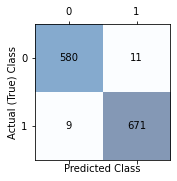

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       591
           1       0.98      0.99      0.99       680

    accuracy                           0.98      1271
   macro avg       0.98      0.98      0.98      1271
weighted avg       0.98      0.98      0.98      1271



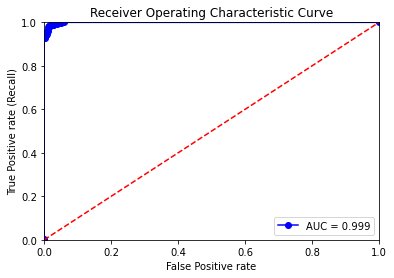

0.9989972130984374

In [96]:
basicvectorizer = TfidfVectorizer(ngram_range=(2,2), min_df = 0.005, max_df = 0.975)
basictrain = basicvectorizer.fit_transform(train.headline)
basictest = basicvectorizer.transform(test.headline)
basicvalidation = basicvectorizer.transform(validation.headline)

mod2 = XGBClassifier(n_estimators = 100, 
                     learning_rate =0.1, 
                     max_depth=4,
                     subsample = 0.75,
                     colsample_bytree = 0.5,
                     reg_alpha = 1,
                     reg_lambda = 1,
                     random_state=42, seed=2, n_jobs = -1)

fit2 = mod2.fit(basictrain, train.Movement)

pred2_train = fit2.predict(basictrain)
pred2_proba_train = fit2.predict_proba(basictrain)

pred2 = fit2.predict(basicvalidation)
pred2_proba = fit2.predict_proba(basicvalidation)

pred2_test = fit2.predict(basictest)
pred2_proba_test = fit2.predict_proba(basictest)

performance(train.Movement, pred2_train, pred2_proba_train)

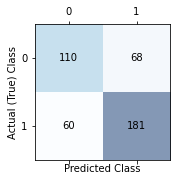

              precision    recall  f1-score   support

           0       0.65      0.62      0.63       178
           1       0.73      0.75      0.74       241

    accuracy                           0.69       419
   macro avg       0.69      0.68      0.69       419
weighted avg       0.69      0.69      0.69       419



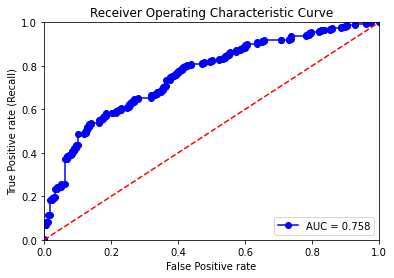

0.758030677420859

In [97]:
performance(validation.Movement, pred2, pred2_proba)

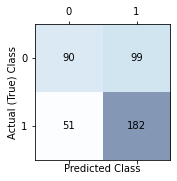

              precision    recall  f1-score   support

           0       0.64      0.48      0.55       189
           1       0.65      0.78      0.71       233

    accuracy                           0.64       422
   macro avg       0.64      0.63      0.63       422
weighted avg       0.64      0.64      0.64       422



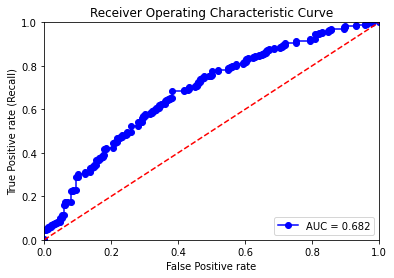

0.682040102640961

In [98]:
performance(test.Movement, pred2_test, pred2_proba_test)

In [133]:
mod2words = basicvectorizer.get_feature_names()
fi = fit2.feature_importances_
fidf = pd.DataFrame({'Words' : mod2words, 
                        'Feature Importance' : fi})

fidf = fidf.sort_values(['Feature Importance', 'Words'], ascending=[0, 1])
fidf.head(20)

,Words,Feature Importance
36355,session low,0.007678
38599,stock hold,0.006282
17195,future rise,0.005424
15567,extend gain,0.005406
38869,stock sell,0.005382
28518,oil price,0.005105
36354,session high,0.005095
24529,loss stock,0.004979
38799,stock rally,0.004951
9912,community downgrade,0.004802


# 3 grams model

In [36]:
# Impute Td-idf instead, we also limit the max appearance and min aappearance of a word to be used in the model. By doing so, many useless features will be eliminated. 
# A gird search is performed to find the best min_df and max_df assuming no change on other hyperparameter of XGBoost yet.
# inheritect the model from our initial model

mod3 = XGBClassifier(n_estimators = 100, 
                     learning_rate =0.1, 
                     max_depth=4,
                     subsample = 0.75,
                     colsample_bytree = 0.5,
                     reg_alpha = 1,
                     reg_lambda = 1,
                     random_state=42, seed=2, n_jobs = -1)

min_df = [0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005]
max_df = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1]

auc_score = np.zeros((len(min_df), len(max_df)))

for i in range(len(min_df)):
    for j in range(len(max_df)):
        if max_df[j] == 1:
            basicvectorizer = TfidfVectorizer(ngram_range=(3,3), min_df = min_df[i])
        else:
            basicvectorizer = TfidfVectorizer(ngram_range=(3,3), min_df = min_df[i], max_df = max_df[j])
        basictrain = basicvectorizer.fit_transform(train.headline)
        basictest = basicvectorizer.transform(test.headline)
        basicvalidation = basicvectorizer.transform(validation.headline)
        
        fit3 = mod3.fit(basictrain, train.Movement)
        pred3 = fit3.predict(basicvalidation)
        pred3_proba = fit3.predict_proba(basicvalidation)
        auc_score[i,j] = score(validation.Movement, pred3_proba)
        print("Finished the model with min_df =", min_df[i], "and max_df = ", max_df[j])

Finished the model with min_df = 0 and max_df =  0.3
Finished the model with min_df = 0 and max_df =  0.4
Finished the model with min_df = 0 and max_df =  0.5
Finished the model with min_df = 0 and max_df =  0.6
Finished the model with min_df = 0 and max_df =  0.7
Finished the model with min_df = 0 and max_df =  0.8
Finished the model with min_df = 0 and max_df =  0.9
Finished the model with min_df = 0 and max_df =  1
Finished the model with min_df = 0.0005 and max_df =  0.3
Finished the model with min_df = 0.0005 and max_df =  0.4
Finished the model with min_df = 0.0005 and max_df =  0.5
Finished the model with min_df = 0.0005 and max_df =  0.6
Finished the model with min_df = 0.0005 and max_df =  0.7
Finished the model with min_df = 0.0005 and max_df =  0.8
Finished the model with min_df = 0.0005 and max_df =  0.9
Finished the model with min_df = 0.0005 and max_df =  1
Finished the model with min_df = 0.001 and max_df =  0.3
Finished the model with min_df = 0.001 and max_df =  0.4
Fi

In [37]:
auc_score.max(axis=1)

array([0.62063499, 0.62063499, 0.60283696, 0.60283696, 0.61113572,
       0.60897944, 0.60897944, 0.61865355, 0.60869971, 0.60869971,
       0.60958553])

In [38]:
auc_score.max(axis=0)

array([0.60958553, 0.60880461, 0.60450371, 0.62063499, 0.61113572,
       0.61113572, 0.61113572, 0.61113572])

In [39]:
auc_score[1, 3]

0.6206349946384446

In [36]:
basicvectorizer = TfidfVectorizer(ngram_range=(3,3), min_df = 0.0005, max_df = 0.6)
basictrain = basicvectorizer.fit_transform(train.headline)
basictest = basicvectorizer.transform(test.headline)
basicvalidation = basicvectorizer.transform(validation.headline)

# Hyperparameter Truning

In [37]:
n_estimators = [10, 30, 50, 100]
max_depth = [1, 2, 4, 6]
learning_rate = 0.1
subsample = [0.25, 0.5, 0.75, 1]
colsample_bytree = [0.25, 0.5, 0.75, 1]
reg_alpha = [0, 1, 2]
reg_lambda = [0, 1, 2]

auc_score = np.zeros((len(n_estimators), len(max_depth), len(subsample), 
               len(colsample_bytree), len(reg_alpha), len(reg_lambda)))

In [38]:
for i in range(len(n_estimators)):
    for j in range(len(max_depth)):
        for k in range(len(subsample)):
            for l in range(len(colsample_bytree)):
                for m in range(len(reg_alpha)):
                    for n in range(len(reg_lambda)):
                        mod = XGBClassifier(learning_rate = learning_rate, 
                                            n_estimators = n_estimators[i], 
                                            max_depth = max_depth[j], 
                                            subsample = subsample[k],
                                            colsample_bytree = colsample_bytree[l],
                                            reg_alpha = reg_alpha[m],
                                            reg_lambda = reg_lambda[n], 
                                            random_state = 42, seed = 2, n_jobs = -1)
                        fit = mod.fit(basictrain, train.Movement)
                        pred = fit.predict(basicvalidation)
                        pred_proba = fit.predict_proba(basicvalidation)
                        auc_score[i,j,k,l,m,n] = score(validation.Movement, pred_proba)
        print("Finished the models with max_depth =", max_depth[j], "for n_estimators =", n_estimators[i])


Finished the models with max_depth = 1 for n_estimators = 10
Finished the models with max_depth = 2 for n_estimators = 10
Finished the models with max_depth = 4 for n_estimators = 10
Finished the models with max_depth = 6 for n_estimators = 10
Finished the models with max_depth = 1 for n_estimators = 30
Finished the models with max_depth = 2 for n_estimators = 30
Finished the models with max_depth = 4 for n_estimators = 30
Finished the models with max_depth = 6 for n_estimators = 30
Finished the models with max_depth = 1 for n_estimators = 50
Finished the models with max_depth = 2 for n_estimators = 50
Finished the models with max_depth = 4 for n_estimators = 50
Finished the models with max_depth = 6 for n_estimators = 50
Finished the models with max_depth = 1 for n_estimators = 100
Finished the models with max_depth = 2 for n_estimators = 100
Finished the models with max_depth = 4 for n_estimators = 100
Finished the models with max_depth = 6 for n_estimators = 100


In [41]:
auc_score.max(axis = 5).max(axis = 4).max(axis = 3).max(axis = 2).max(axis = 1)

array([0.59992307, 0.63979673, 0.64229102, 0.6525479 ])

In [42]:
auc_score.max(axis = 5).max(axis = 4).max(axis = 3).max(axis = 2).max(axis = 0)

array([0.62671919, 0.6525479 , 0.64537974, 0.64577603])

In [43]:
auc_score.max(axis = 5).max(axis = 4).max(axis = 3).max(axis = 1).max(axis = 0)

array([0.59985314, 0.61612429, 0.63926057, 0.6525479 ])

In [44]:
auc_score.max(axis = 5).max(axis = 4).max(axis = 2).max(axis = 1).max(axis = 0)

array([0.6525479 , 0.65041494, 0.62810621, 0.63181267])

In [45]:
auc_score.max(axis = 5).max(axis = 3).max(axis = 2).max(axis = 1).max(axis = 0)

array([0.6525479 , 0.63617185, 0.63699939])

In [46]:
auc_score.max(axis = 4).max(axis = 3).max(axis = 2).max(axis = 1).max(axis = 0)

array([0.6525479 , 0.63844468, 0.62082148])

In [47]:
auc_score[3, 1, 3, 0, 0, 0]

0.6525479043312044

We choose hyperparameter:

n_estimators = 100

max_depth = 2

subsample = 1

colsample_bytree = 0.25

reg_alpha = 0

reg_lambda = 0

As our finalised 3-grams model

# Finallised 3-grams model

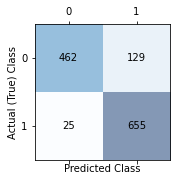

              precision    recall  f1-score   support

           0       0.95      0.78      0.86       591
           1       0.84      0.96      0.89       680

    accuracy                           0.88      1271
   macro avg       0.89      0.87      0.88      1271
weighted avg       0.89      0.88      0.88      1271



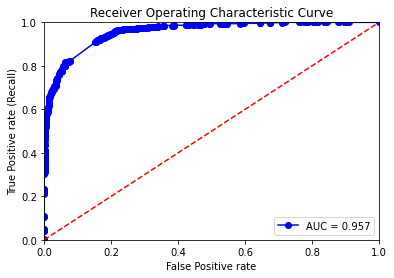

0.9574176371056038

In [99]:
basicvectorizer = TfidfVectorizer(ngram_range=(3,3), min_df = 0.0005, max_df = 0.6)
basictrain = basicvectorizer.fit_transform(train.headline)
basictest = basicvectorizer.transform(test.headline)
basicvalidation = basicvectorizer.transform(validation.headline)

mod3 = XGBClassifier(n_estimators = 100, 
                     learning_rate =0.1, 
                     max_depth=2,
                     subsample = 1,
                     colsample_bytree = 0.25,
                     reg_alpha = 0,
                     reg_lambda = 0,
                     random_state=42, seed=2, n_jobs = -1)

fit3 = mod3.fit(basictrain, train.Movement)

pred3_train = fit3.predict(basictrain)
pred3_proba_train = fit3.predict_proba(basictrain)

pred3 = fit3.predict(basicvalidation)
pred3_proba = fit3.predict_proba(basicvalidation)

pred3_test = fit3.predict(basictest)
pred3_proba_test = fit3.predict_proba(basictest)

performance(train.Movement, pred3_train, pred3_proba_train)

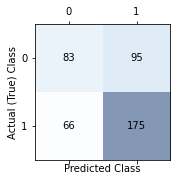

              precision    recall  f1-score   support

           0       0.56      0.47      0.51       178
           1       0.65      0.73      0.68       241

    accuracy                           0.62       419
   macro avg       0.60      0.60      0.60       419
weighted avg       0.61      0.62      0.61       419



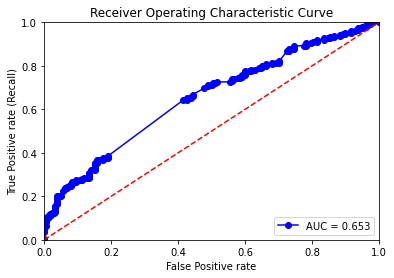

0.6525479043312044

In [100]:
performance(validation.Movement, pred3, pred3_proba)

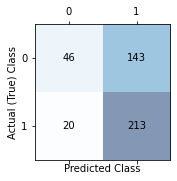

              precision    recall  f1-score   support

           0       0.70      0.24      0.36       189
           1       0.60      0.91      0.72       233

    accuracy                           0.61       422
   macro avg       0.65      0.58      0.54       422
weighted avg       0.64      0.61      0.56       422



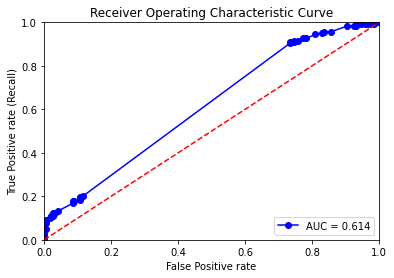

0.613802030111043

In [101]:
performance(test.Movement, pred3_test, pred3_proba_test)

In [49]:
mod3words = basicvectorizer.get_feature_names()
fi = fit3.feature_importances_
fidf = pd.DataFrame({'Words' : mod3words, 
                        'Feature Importance' : fi})

fidf = fidf.sort_values(['Feature Importance', 'Words'], ascending=[0, 1])
fidf.head(20)

,Words,Feature Importance
1828282,stock add gain,0.018668
230914,blog stock fall,0.017753
230962,blog stock hold,0.016464
1845661,stock open low,0.014399
1845652,stock open high,0.014251
1836067,stock extend loss,0.014205
266725,brief thing know,0.014105
1836064,stock extend gain,0.013728
546583,diamond rough tale,0.013700
1638502,rise unusual volume,0.013273


The 1 gram, 2 grams and 3 grams models have testing performance of 57.3, 68.2, 61.4 AUC respectively. It show the relation between financial news and the market! However, These models obversiously weak learners. Can e further improve the model by using all three model prediction?

# Ensemble Model using 3 weak learners

In this section, we use the prediction on validation set from these models as the features and regress them to the actual classification. Theoretically, the final error rate will be reduced as the input is not totally dependent. 

In [102]:
E_validation = pd.DataFrame({"y": validation.Movement, "x1": pd.DataFrame(pred1_proba)[1], "x2": pd.DataFrame(pred2_proba)[1], "x3": pd.DataFrame(pred3_proba)[1]} )

In [103]:
E_test = pd.DataFrame({"y": test.Movement, "x1": pd.DataFrame(pred1_proba_test)[1], "x2": pd.DataFrame(pred2_proba_test)[1], "x3": pd.DataFrame(pred3_proba_test)[1]} )

In [104]:
E_validation.head()

,y,x1,x2,x3
0,0,0.393619,0.556218,0.491502
1,0,0.753973,0.502511,0.534821
2,0,0.403150,0.464426,0.534821
3,1,0.646255,0.258831,0.534821
4,1,0.255079,0.900774,0.534821


In [105]:
en1 =  LogisticRegression(solver = "liblinear")

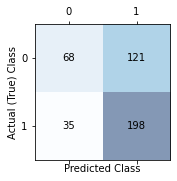

              precision    recall  f1-score   support

           0       0.66      0.36      0.47       189
           1       0.62      0.85      0.72       233

    accuracy                           0.63       422
   macro avg       0.64      0.60      0.59       422
weighted avg       0.64      0.63      0.60       422



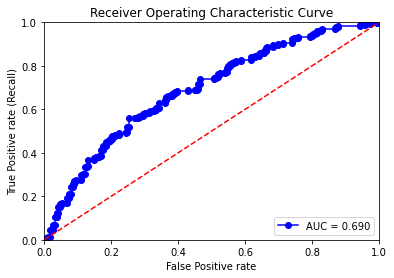

0.6897835910711447

In [106]:
fin_mod = en1.fit(E_validation.iloc[:, 1:4], E_validation.y)
fin_pred = fin_mod.predict(E_test.iloc[:, 1:4])
fin_pred_proba = fin_mod.predict_proba(E_test.iloc[:, 1:4])
performance(E_test.y, fin_pred, fin_pred_proba)

In [107]:
fin_mod.coef_

array([[2.06463072, 3.44993756, 0.32050959]])

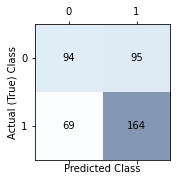

              precision    recall  f1-score   support

           0       0.58      0.50      0.53       189
           1       0.63      0.70      0.67       233

    accuracy                           0.61       422
   macro avg       0.60      0.60      0.60       422
weighted avg       0.61      0.61      0.61       422



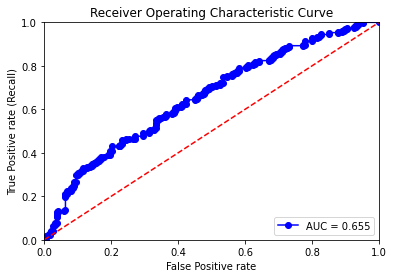

0.6551763289960715

In [108]:
en2 = XGBClassifier()
fin_mod2 = en2.fit(E_validation.iloc[:, 1:4], E_validation.y)
fin_pred2 = fin_mod2.predict(E_test.iloc[:, 1:4])
fin_pred2_proba = fin_mod2.predict_proba(E_test.iloc[:, 1:4])
performance(E_test.y, fin_pred2, fin_pred2_proba)

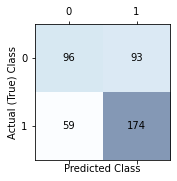

              precision    recall  f1-score   support

           0       0.62      0.51      0.56       189
           1       0.65      0.75      0.70       233

    accuracy                           0.64       422
   macro avg       0.64      0.63      0.63       422
weighted avg       0.64      0.64      0.63       422



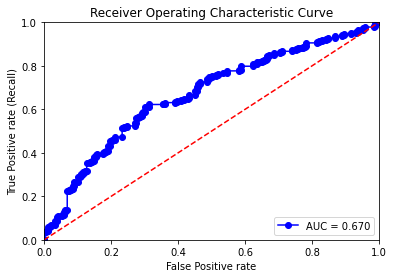

0.6701069555146808

In [109]:
en3 =  svm.SVC(probability=True)
fin_mod3 = en3.fit(E_validation.iloc[:, 1:4], E_validation.y)
fin_pred3 = fin_mod3.predict(E_test.iloc[:, 1:4])
fin_pred3_proba = fin_mod3.predict_proba(E_test.iloc[:, 1:4])
performance(E_test.y, fin_pred3, fin_pred3_proba)

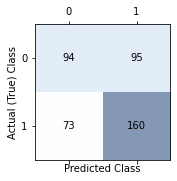

              precision    recall  f1-score   support

           0       0.56      0.50      0.53       189
           1       0.63      0.69      0.66       233

    accuracy                           0.60       422
   macro avg       0.60      0.59      0.59       422
weighted avg       0.60      0.60      0.60       422



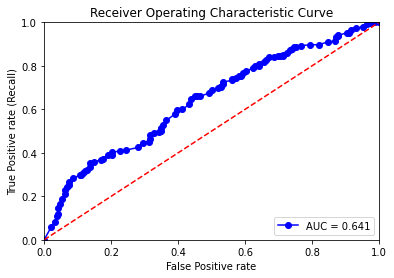

0.6406203874015033

In [111]:
en4 = RandomForestClassifier()
fin_mod4 = en4.fit(E_validation.iloc[:, 1:4], E_validation.y)
fin_pred4 = fin_mod4.predict(E_test.iloc[:, 1:4])
fin_pred4_proba = fin_mod4.predict_proba(E_test.iloc[:, 1:4])
performance(E_test.y, fin_pred4, fin_pred4_proba)

Combination of models using L2 logistic Regression provides us a slightly better performance, 0.69 AUC, 63% accuracy. If one can win over 0.63 in the financial market, he will gain a lot. Next, we will need to check whether the financial news is a leading or lagging indicator. 